In [1]:
import sys
sys.path.append('/storage/vbutoi/projects')
sys.path.append('/storage/vbutoi/libraries')
sys.path.append('/storage/vbutoi/projects/ESE')
sys.path.append('/storage/vbutoi/projects/UniverSeg')

from ionpy.analysis import ResultsLoader
from ese.experiment.experiment import CalibrationExperiment
import seaborn as sns
sns.set_style("darkgrid")

import os 
os.environ['DATAPATH'] = ':'.join((
       '/storage/vbutoi/datasets',
))
os.environ["CUDA_VISIBLE_DEVICES"] = '3' 

%load_ext yamlmagic
%load_ext autoreload
%autoreload 2

In [2]:
# Results loader object does everything
rs = ResultsLoader()
root = "/storage/vbutoi/scratch/ESE"

In [3]:
path = f"{root}/WMH_aug_runs"

dfc = rs.load_configs(
    path,
    properties=False,
)

df = rs.load_metrics(dfc)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [4]:
best_exp = rs.get_experiment(
    df=df,
    exp_class=CalibrationExperiment,
    metric="val-dice_score",
    checkpoint="max-val-dice_score",
    device="cuda"
)

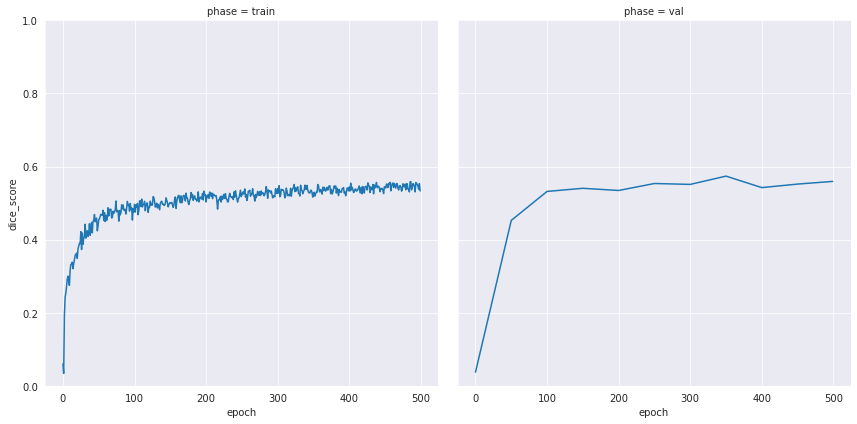

In [5]:
best_exp.vis_loss_curves(height=6)

In [6]:
%%yaml dataset_cfg 

_class: ese.experiment.datasets.WMH
annotator: observer_o12
axis: 0
split: val 
num_slices: 1
slicing: midslice 
task: Amsterdam 
version: 0.2

<IPython.core.display.Javascript object>

In [7]:
from ionpy.experiment.util import absolute_import
from torch.utils.data import DataLoader

dataset_cls = absolute_import(dataset_cfg.pop("_class"))
WMH_Dataset = dataset_cls(**dataset_cfg)
wmh_dataloader = DataLoader(WMH_Dataset, batch_size=1, shuffle=False, drop_last=False)

In [8]:
from ionpy.util.torchutils import to_device
import torch
from tqdm.notebook import tqdm
import einops

def get_dataset_perf(
        exp, 
        dataloader, 
        ):

    items = []
    with torch.no_grad():
        for _, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
            
            # Get your image label pair and define some regions.
            x, y = to_device(batch, exp.device)
            # Reshape to a good size
            x = einops.rearrange(x, "b c h w -> (b c) 1 h w")
            y = einops.rearrange(y, "b c h w -> (b c) 1 h w")
            # Get the prediction
            yhat = exp.model(x)  
            # Extract predictions
            soft_pred = torch.sigmoid(yhat)
            # Get the hard prediction
            hard_pred = (soft_pred > 0.5).float()
            # Wrap it in an item
            items.append({
                "image": x.cpu().squeeze(),
                "label": y.cpu().squeeze(),
                "soft_pred": soft_pred.cpu().squeeze(),
                "hard_pred": hard_pred.cpu().squeeze(),
            })

    return items

In [9]:
# val_perf is a dict where each item is the subj id
# with the y, ypred, yloss, ydice
predictions_dict = get_dataset_perf(
    exp=best_exp, 
    dataloader=wmh_dataloader
    )

  0%|          | 0/15 [00:00<?, ?it/s]

Graph Bins:  tensor([0.5000, 0.5500, 0.6000, 0.6500, 0.7000, 0.7500, 0.8000])
Graph Bars:  tensor([0.2000, 0.2500, 0.3333, 1.0000, 0.6667, 0.0000, 0.0000])
Graph Widths:  tensor([0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500])

Graph Bins:  tensor([0.5013, 0.5469, 0.5590, 0.5694, 0.5875, 0.6214, 0.6316, 0.6905, 0.7271,
        0.7933])
Graph Bars:  tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.5000, 0.0000, 1.0000, 1.0000,
        0.0000])
Graph Widths:  tensor([0.0265, 0.0052, 0.0070, 0.0172, 0.0323, 0.0033, 0.0259, 0.0122, 0.0193,
        0.0436])

Graph Bins:  tensor([0.5000, 0.5500, 0.6000, 0.6500, 0.7000, 0.7500, 0.8000])
Graph Bars:  tensor([0.2000, 0.2500, 0.4167, 1.0000, 0.5000, 0.0000, 0.0000])
Graph Widths:  tensor([0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500])



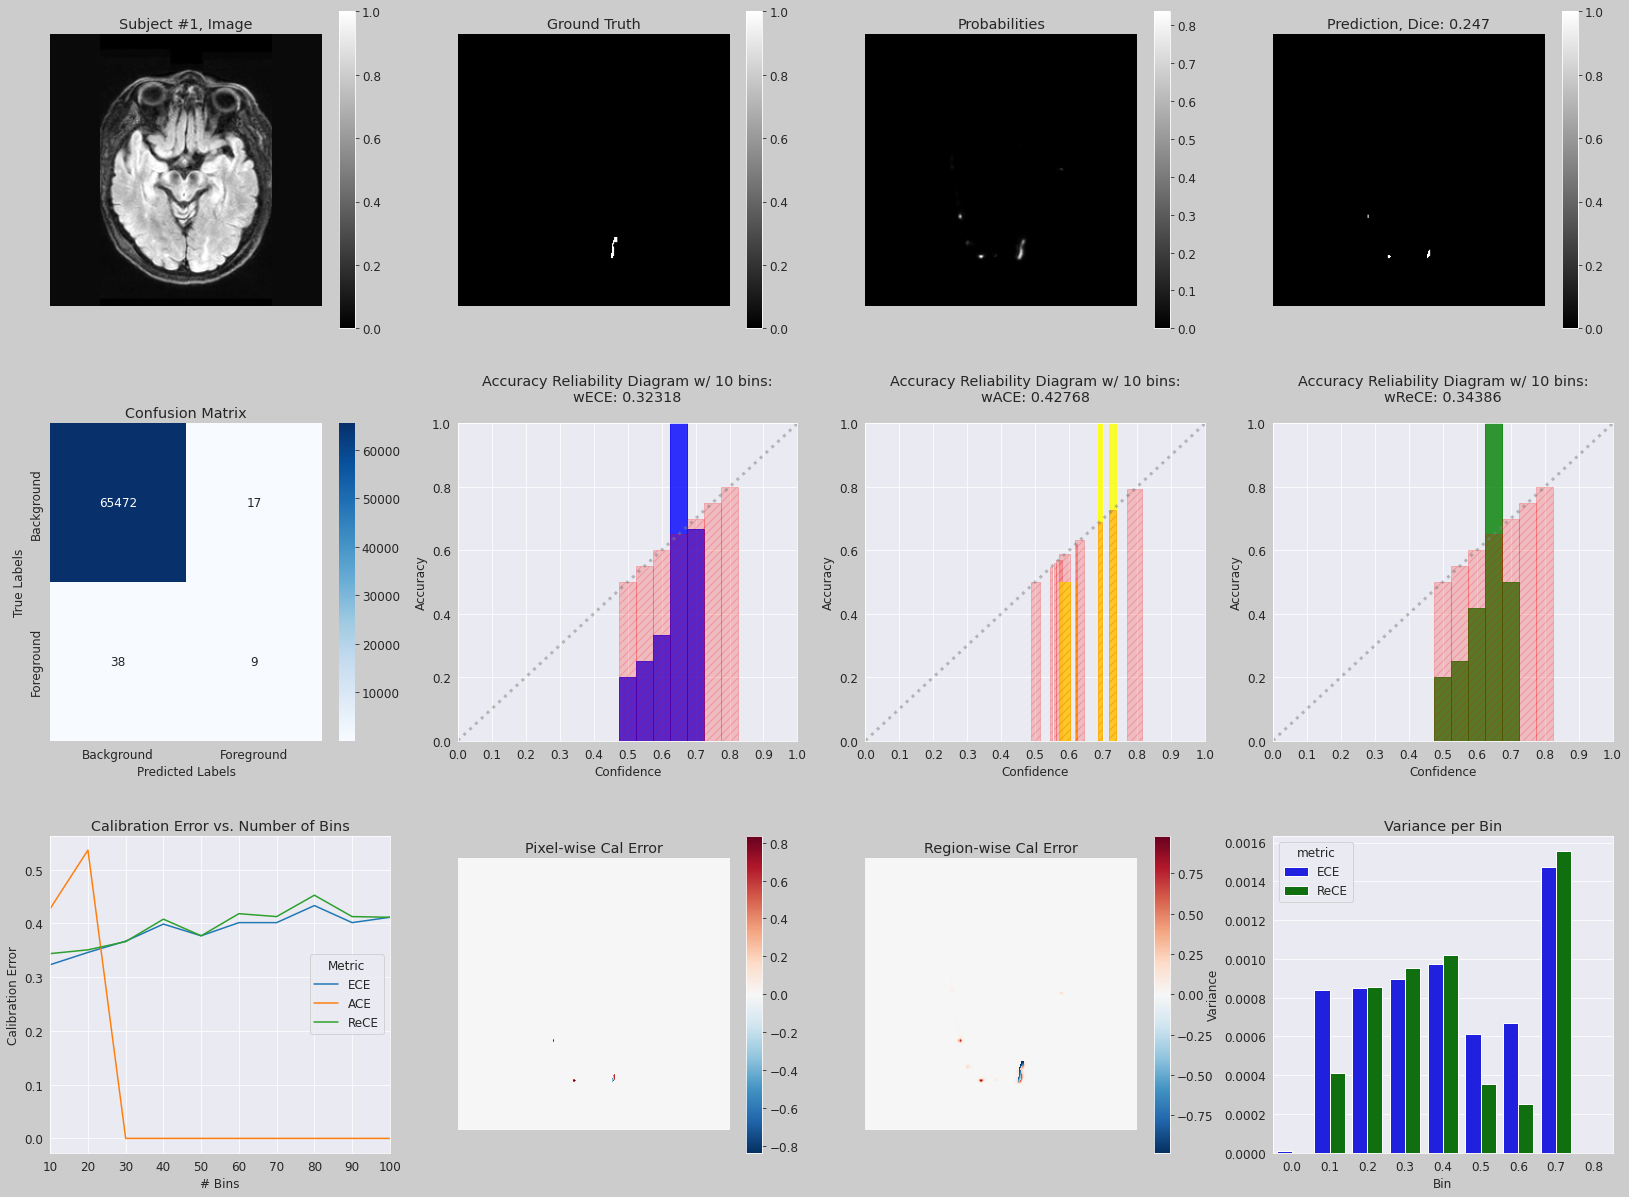

Graph Bins:  tensor([0.5000, 0.5500, 0.7000, 0.7500, 0.8500, 0.9000, 0.9500])
Graph Bars:  tensor([1.0000, 0.3333, 1.0000, 0.6667, 0.2500, 0.6000, 0.6667])
Graph Widths:  tensor([0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500])

Graph Bins:  tensor([0.5089, 0.5749, 0.7588, 0.8587, 0.8830, 0.9256, 0.9648, 0.9968, 0.9993,
        0.9999])
Graph Bars:  tensor([1.0000, 0.5000, 0.5000, 0.5000, 0.0000, 0.5000, 0.5000, 1.0000, 0.0000,
        1.0000])
Graph Widths:  tensor([4.8525e-02, 1.2625e-01, 3.6808e-02, 1.8694e-02, 3.2189e-02, 1.1451e-02,
        3.1031e-02, 2.1823e-03, 3.2973e-04, 9.5367e-06])

Graph Bins:  tensor([0.5000, 0.5500, 0.7000, 0.7500, 0.8500, 0.9000, 0.9500])
Graph Bars:  tensor([1.0000, 0.3333, 1.0000, 0.6667, 0.2500, 0.6000, 0.6500])
Graph Widths:  tensor([0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500])



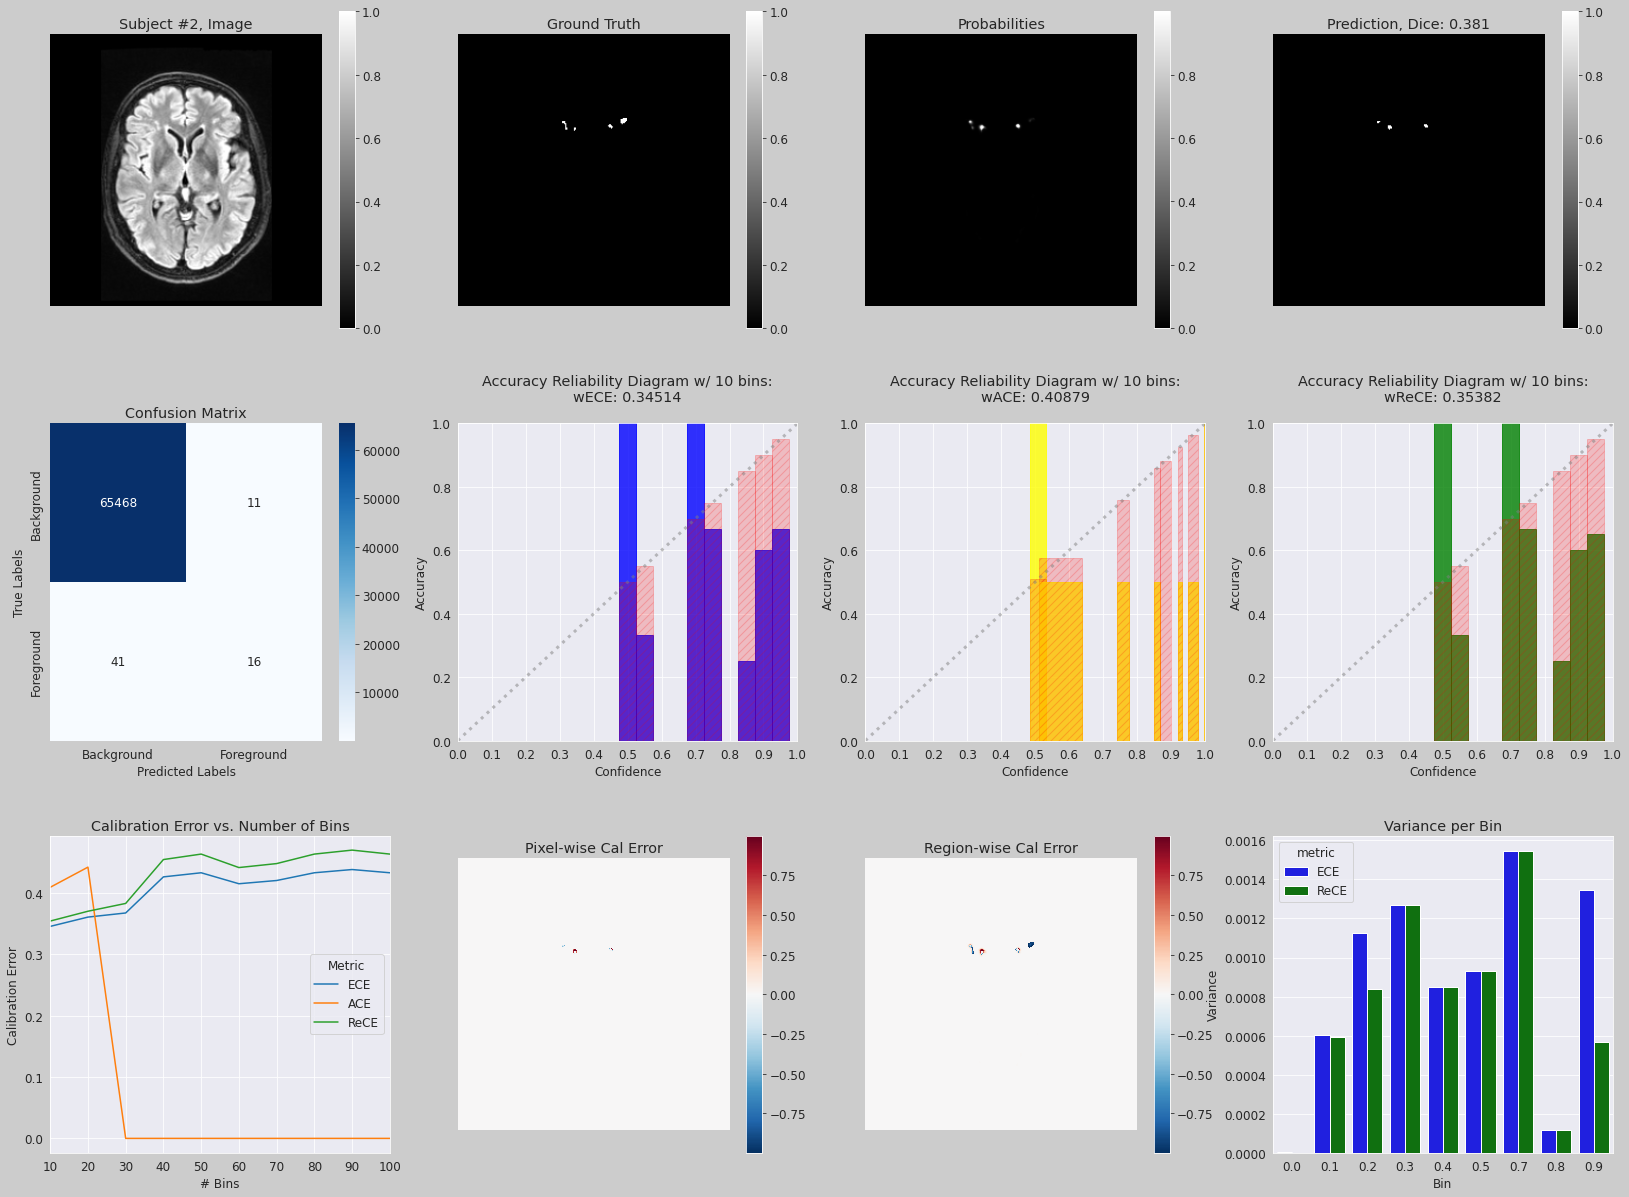

Graph Bins:  tensor([0.5000, 0.5500, 0.6000, 0.6500, 0.7000, 0.7500, 0.8000, 0.8500, 0.9000,
        0.9500])
Graph Bars:  tensor([0.2500, 0.2143, 0.2105, 0.6667, 0.4375, 0.4211, 0.2353, 0.3889, 0.5484,
        0.5241])
Graph Widths:  tensor([0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500,
        0.0500])

Graph Bins:  tensor([0.5065, 0.6004, 0.7001, 0.7979, 0.8887, 0.9598, 0.9826, 0.9937, 0.9977,
        0.9992])
Graph Bars:  tensor([0.2424, 0.3939, 0.4242, 0.3333, 0.5455, 0.5625, 0.4688, 0.4375, 0.2812,
        0.8750])
Graph Widths:  tensor([0.0927, 0.0987, 0.0970, 0.0896, 0.0650, 0.0224, 0.0109, 0.0040, 0.0015,
        0.0006])

Graph Bins:  tensor([0.5000, 0.5500, 0.6000, 0.6500, 0.7000, 0.7500, 0.8000, 0.8500, 0.9000,
        0.9500])
Graph Bars:  tensor([0.2778, 0.2308, 0.2105, 0.6667, 0.4667, 0.3529, 0.2667, 0.3750, 0.4130,
        0.3164])
Graph Widths:  tensor([0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500,
        0.0500])



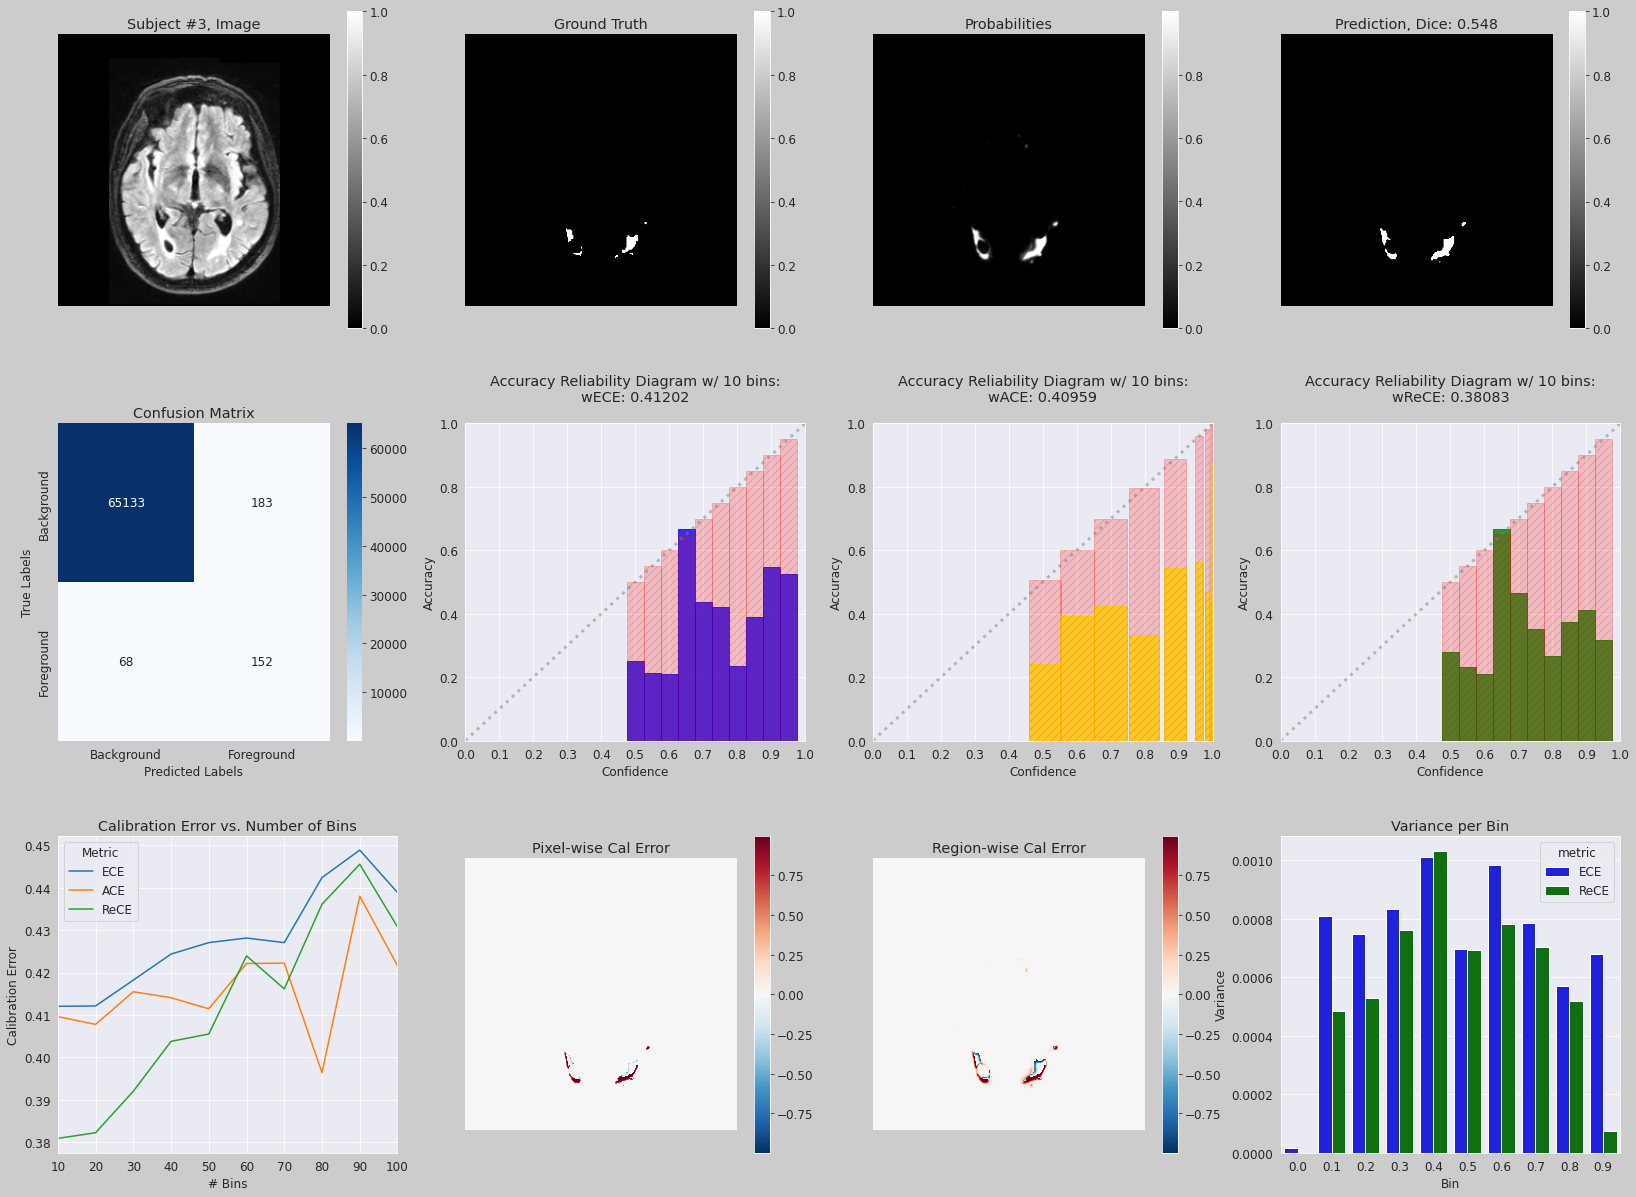

Graph Bins:  tensor([0.5000, 0.5500, 0.6000, 0.6500, 0.7000, 0.7500, 0.8000, 0.8500, 0.9000,
        0.9500])
Graph Bars:  tensor([0.2667, 0.2727, 0.4000, 0.2500, 0.6923, 0.7000, 0.3333, 0.2000, 0.7500,
        0.3077])
Graph Widths:  tensor([0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500,
        0.0500])

Graph Bins:  tensor([0.5092, 0.5668, 0.6290, 0.6963, 0.7565, 0.8168, 0.9284, 0.9786, 0.9925,
        0.9974])
Graph Bars:  tensor([0.2857, 0.3077, 0.2308, 0.6923, 0.6154, 0.3846, 0.3846, 0.1538, 0.3846,
        0.3846])
Graph Widths:  tensor([0.0386, 0.0520, 0.0614, 0.0532, 0.0599, 0.1032, 0.0498, 0.0133, 0.0048,
        0.0018])

Graph Bins:  tensor([0.5000, 0.5500, 0.6000, 0.6500, 0.7000, 0.7500, 0.8000, 0.8500, 0.9000,
        0.9500])
Graph Bars:  tensor([0.3077, 0.3333, 0.3750, 0.2500, 0.6667, 0.7778, 0.2500, 0.2000, 0.7500,
        0.5875])
Graph Widths:  tensor([0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500,
        0.0500])



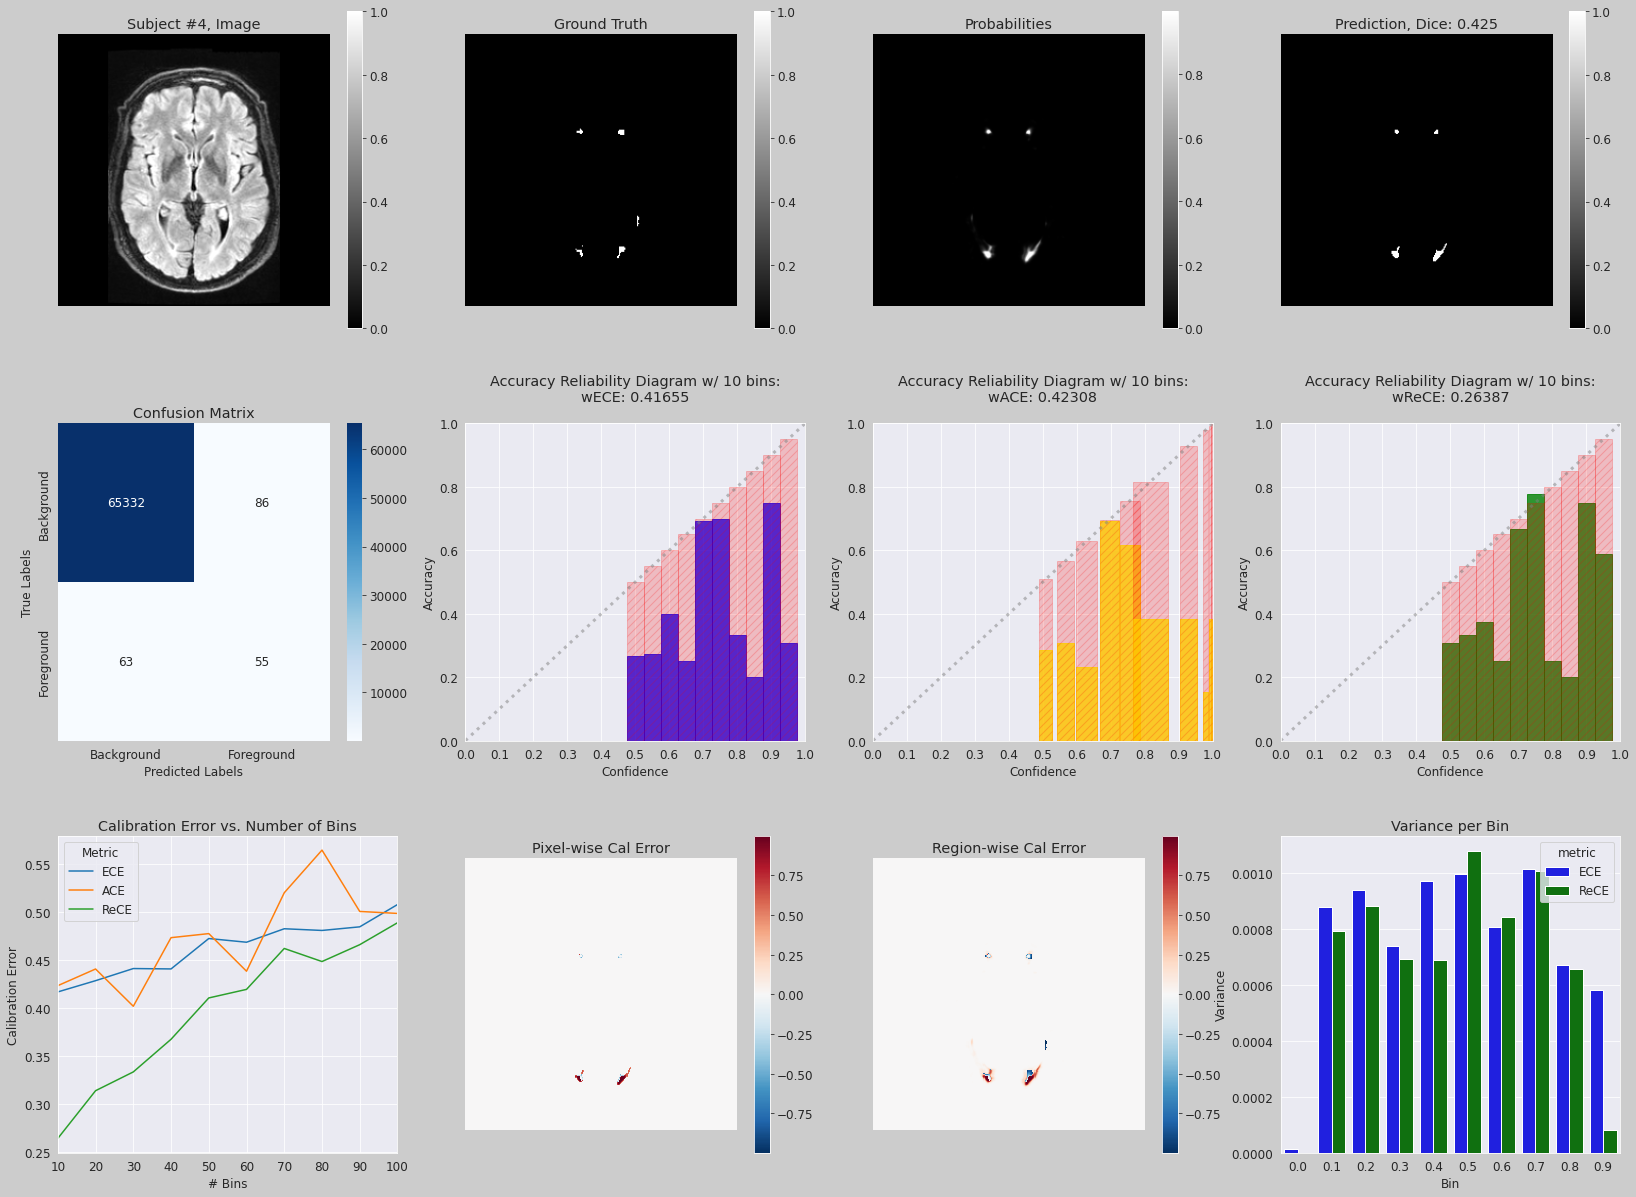

Graph Bins:  tensor([0.5000, 0.5500, 0.6000, 0.6500, 0.7000, 0.7500, 0.8000, 0.8500, 0.9000,
        0.9500])
Graph Bars:  tensor([0.2143, 0.3846, 0.5000, 0.4615, 0.5000, 0.5714, 0.5000, 0.7778, 0.6429,
        0.9012])
Graph Widths:  tensor([0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500,
        0.0500])

Graph Bins:  tensor([0.5028, 0.5778, 0.6468, 0.7302, 0.8039, 0.8853, 0.9629, 0.9815, 0.9909,
        0.9971])
Graph Bars:  tensor([0.2105, 0.5263, 0.4211, 0.5789, 0.5789, 0.6842, 0.7778, 0.9444, 0.8889,
        1.0000])
Graph Widths:  tensor([0.0716, 0.0681, 0.0767, 0.0667, 0.0798, 0.0772, 0.0179, 0.0090, 0.0052,
        0.0028])

Graph Bins:  tensor([0.5000, 0.5500, 0.6000, 0.6500, 0.7000, 0.7500, 0.8000, 0.8500, 0.9000,
        0.9500])
Graph Bars:  tensor([0.2143, 0.4000, 0.4615, 0.3636, 0.5000, 0.5385, 0.5000, 0.7778, 0.6667,
        0.7722])
Graph Widths:  tensor([0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500,
        0.0500])



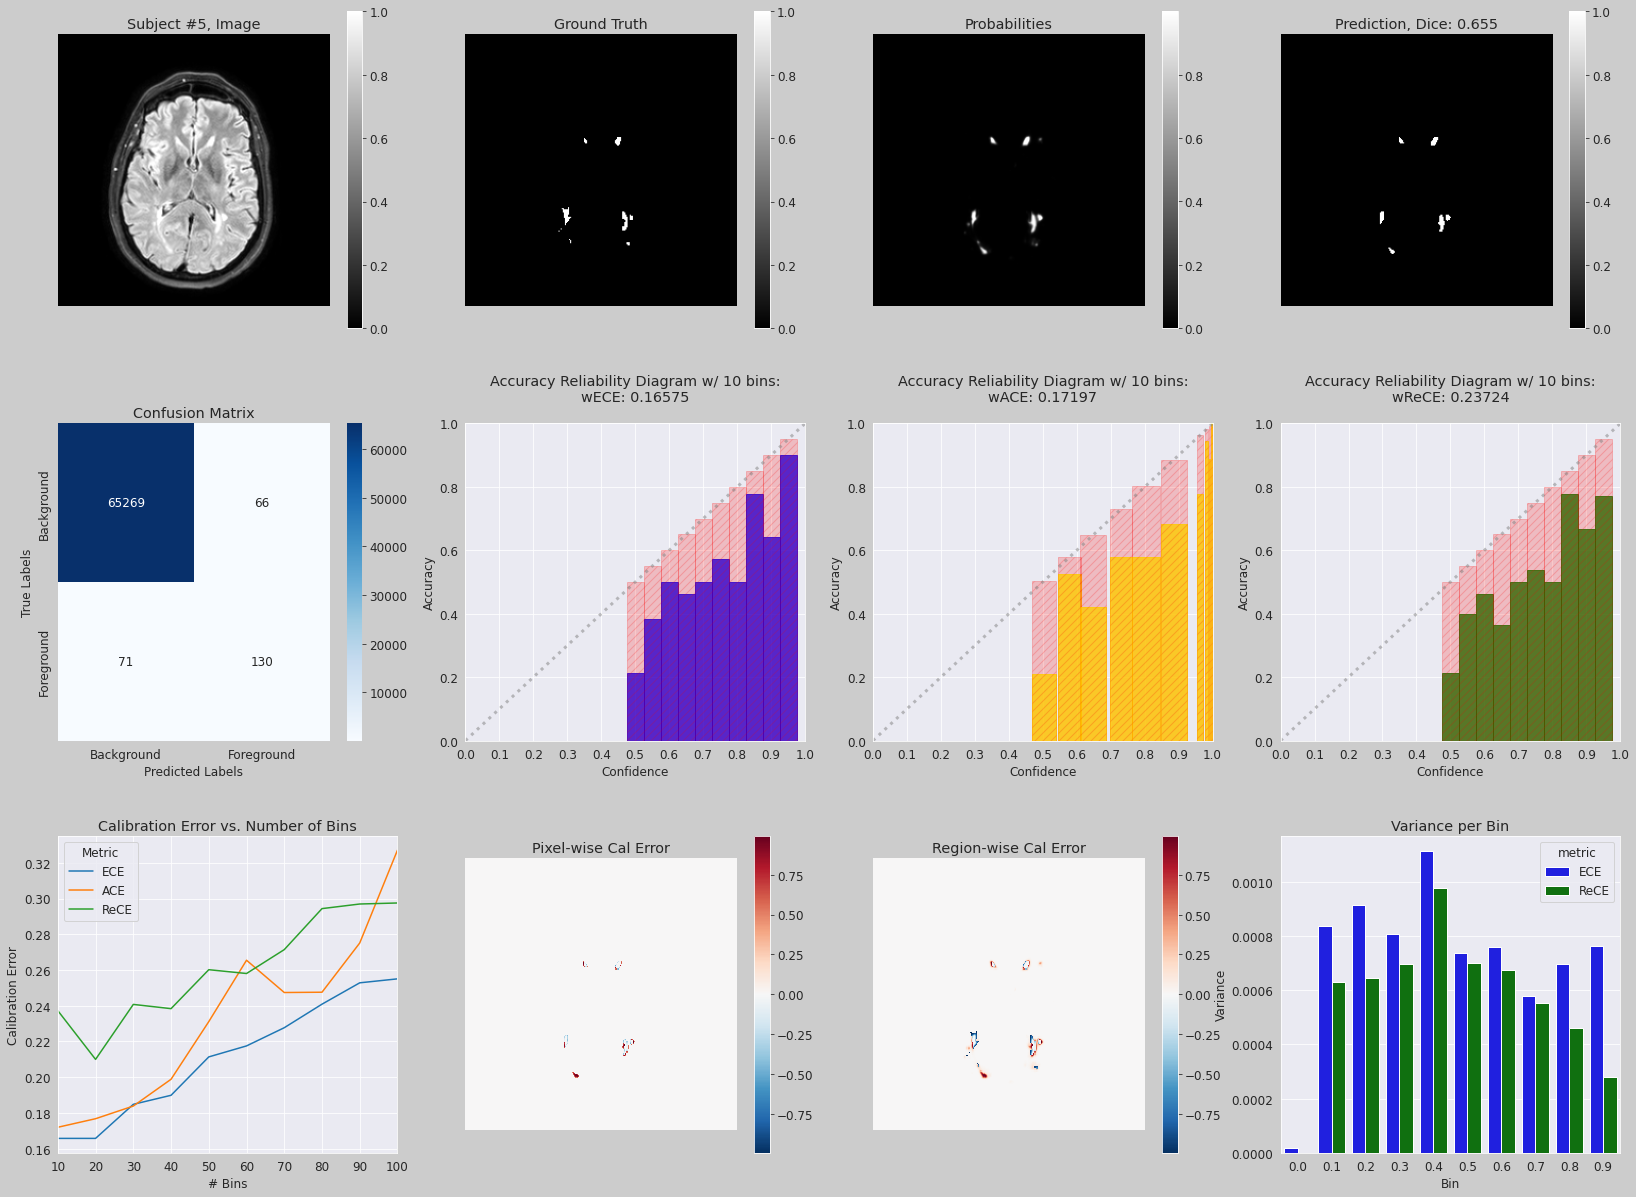

Graph Bins:  tensor([0.5000, 0.5500, 0.6000, 0.6500, 0.7000, 0.7500, 0.8000, 0.8500, 0.9000,
        0.9500])
Graph Bars:  tensor([0.4000, 0.7000, 0.7500, 0.4000, 0.8000, 0.4545, 0.7000, 0.7143, 0.9167,
        0.9505])
Graph Widths:  tensor([0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500,
        0.0500])

Graph Bins:  tensor([0.5028, 0.6517, 0.8047, 0.9339, 0.9867, 0.9957, 0.9984, 0.9991, 0.9993,
        0.9995])
Graph Bars:  tensor([0.5926, 0.5185, 0.6923, 0.7308, 0.9231, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000])
Graph Widths:  tensor([0.1421, 0.1522, 0.1181, 0.0519, 0.0086, 0.0027, 0.0007, 0.0002, 0.0002,
        0.0004])

Graph Bins:  tensor([0.5000, 0.5500, 0.6000, 0.6500, 0.7000, 0.7500, 0.8000, 0.8500, 0.9000,
        0.9500])
Graph Bars:  tensor([0.4444, 0.7000, 0.7500, 0.4000, 0.8000, 0.4545, 0.6667, 0.7143, 0.9000,
        0.9518])
Graph Widths:  tensor([0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500,
        0.0500])



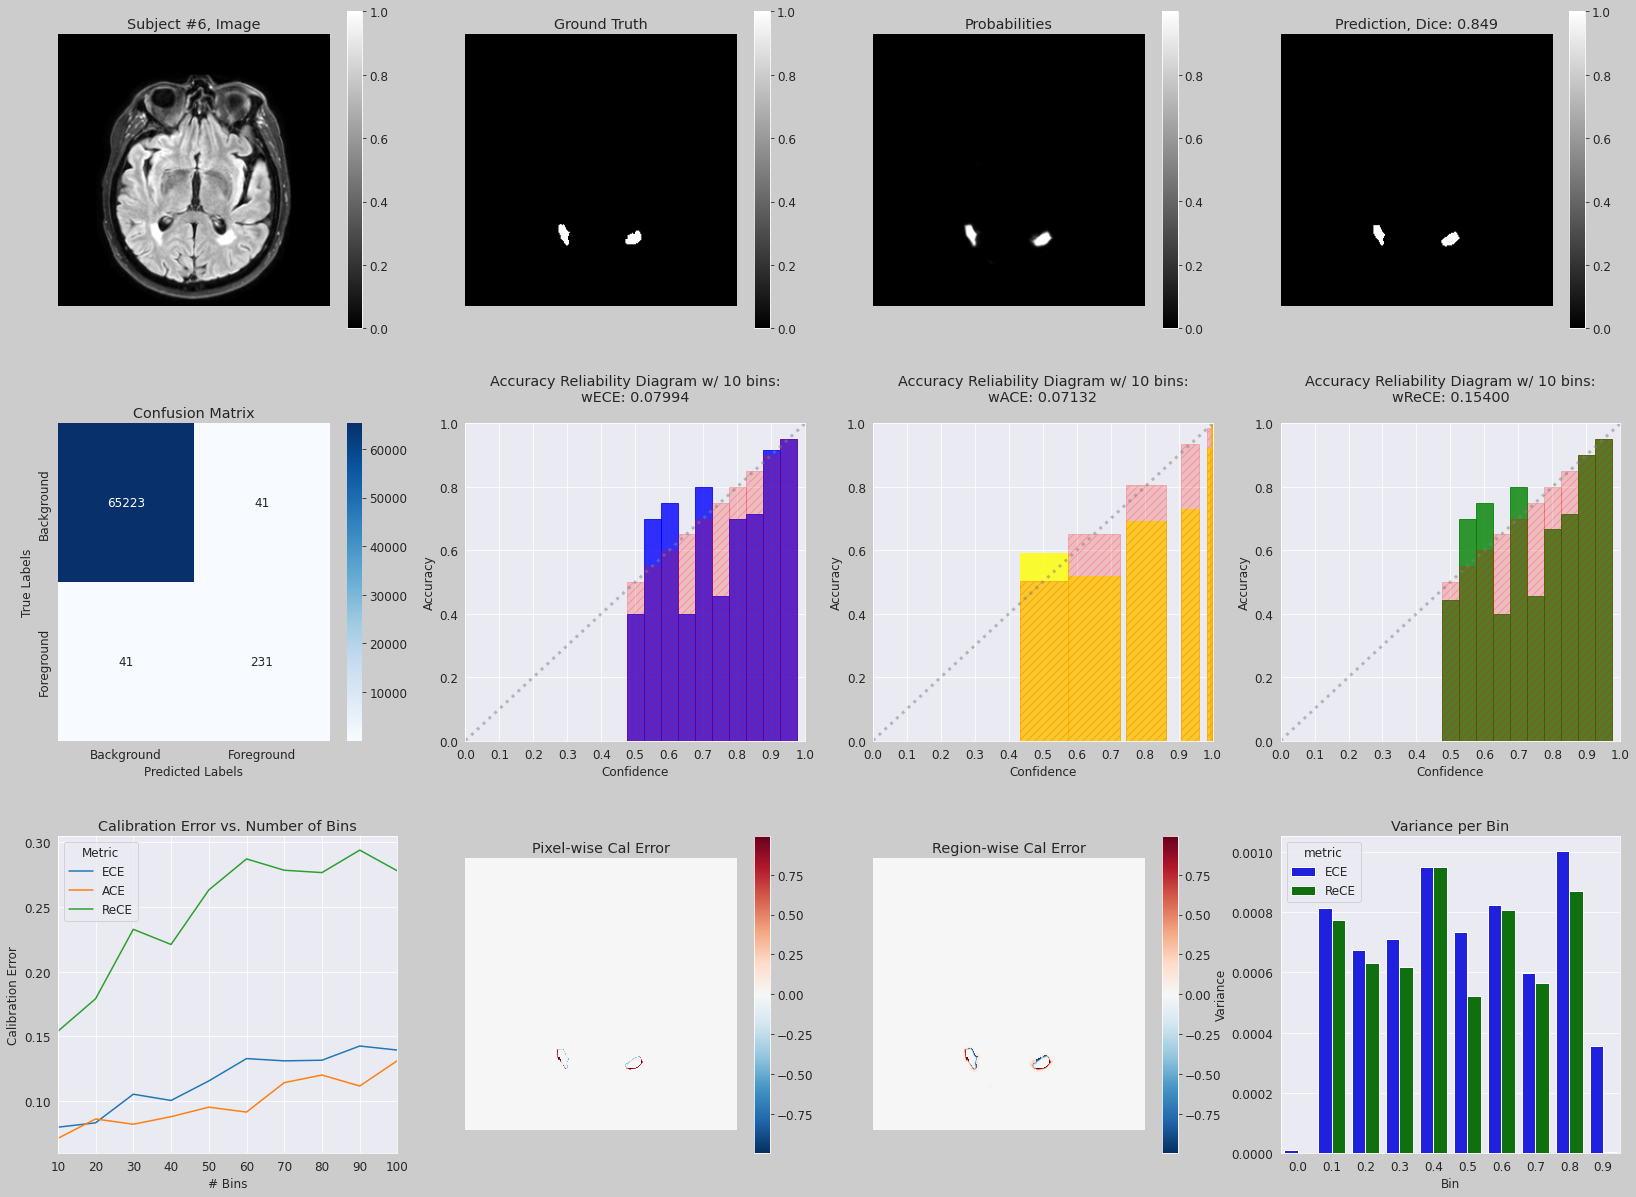

Graph Bins:  tensor([0.5000, 0.5500, 0.6000, 0.6500, 0.7000, 0.7500, 0.8000, 0.8500, 0.9000,
        0.9500])
Graph Bars:  tensor([0.2727, 0.3750, 0.2609, 0.3125, 0.2692, 0.3846, 0.2500, 0.5909, 0.4615,
        0.3968])
Graph Widths:  tensor([0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500,
        0.0500])

Graph Bins:  tensor([0.5011, 0.5609, 0.6264, 0.6833, 0.7582, 0.8341, 0.9128, 0.9654, 0.9935,
        0.9983])
Graph Bars:  tensor([0.2778, 0.3611, 0.2571, 0.3429, 0.4000, 0.4286, 0.4000, 0.4286, 0.4000,
        0.4571])
Graph Widths:  tensor([0.0568, 0.0593, 0.0516, 0.0656, 0.0740, 0.0762, 0.0525, 0.0280, 0.0048,
        0.0011])

Graph Bins:  tensor([0.5000, 0.5500, 0.6000, 0.6500, 0.7000, 0.7500, 0.8000, 0.8500, 0.9000,
        0.9500])
Graph Bars:  tensor([0.2533, 0.3833, 0.2857, 0.2963, 0.2826, 0.3636, 0.2500, 0.5750, 0.4444,
        0.5763])
Graph Widths:  tensor([0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500,
        0.0500])



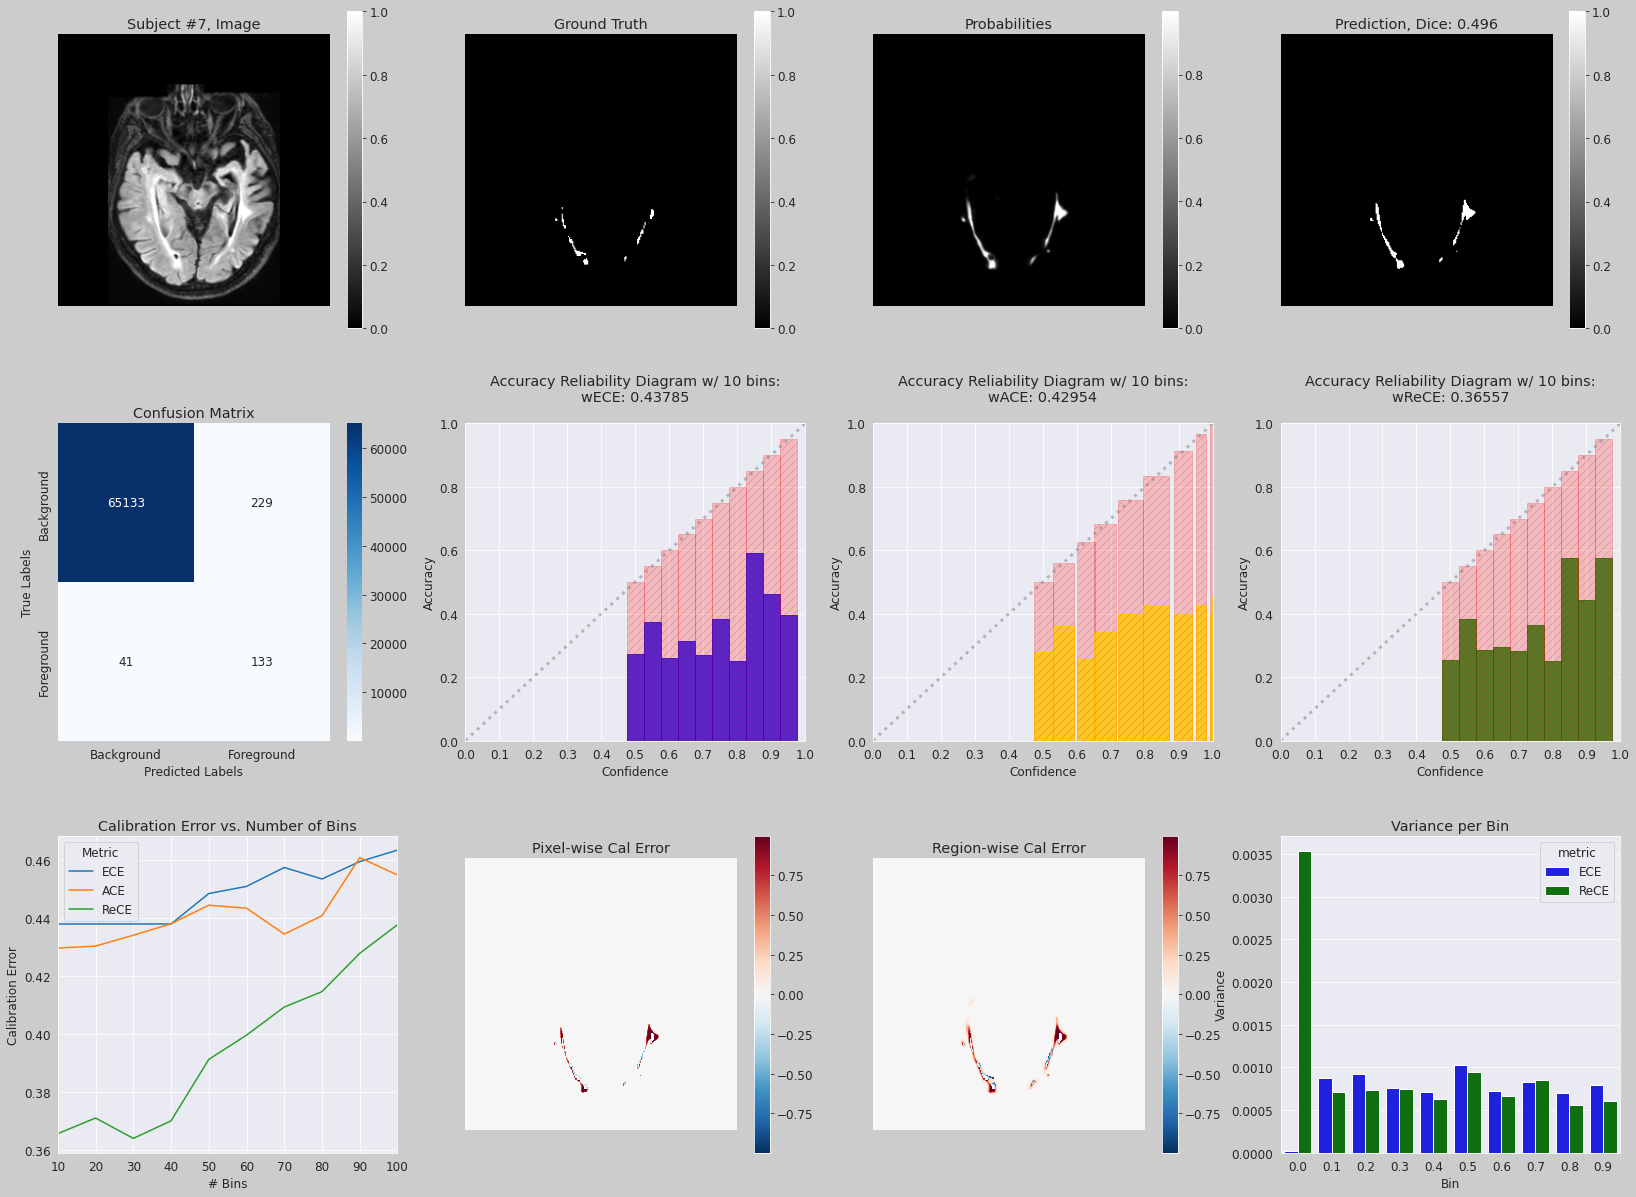

Graph Bins:  tensor([0.5000, 0.5500, 0.6000, 0.6500, 0.7500, 0.8000, 0.8500, 0.9000, 0.9500])
Graph Bars:  tensor([0.4286, 0.3333, 0.4286, 0.0000, 0.2500, 1.0000, 1.0000, 1.0000, 0.9333])
Graph Widths:  tensor([0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500])

Graph Bins:  tensor([0.5093, 0.5433, 0.6041, 0.6271, 0.7858, 0.8739, 0.9311, 0.9806, 0.9987,
        0.9993])
Graph Bars:  tensor([0.5000, 0.5000, 0.5000, 0.0000, 0.7500, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000])
Graph Widths:  tensor([0.0183, 0.0536, 0.0209, 0.1523, 0.0692, 0.0458, 0.0467, 0.0176, 0.0005,
        0.0005])

Graph Bins:  tensor([0.5000, 0.5500, 0.6000, 0.6500, 0.7500, 0.8000, 0.8500, 0.9000, 0.9500])
Graph Bars:  tensor([0.5000, 0.3333, 0.4167, 0.0000, 0.2500, 1.0000, 1.0000, 1.0000, 0.9545])
Graph Widths:  tensor([0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500])



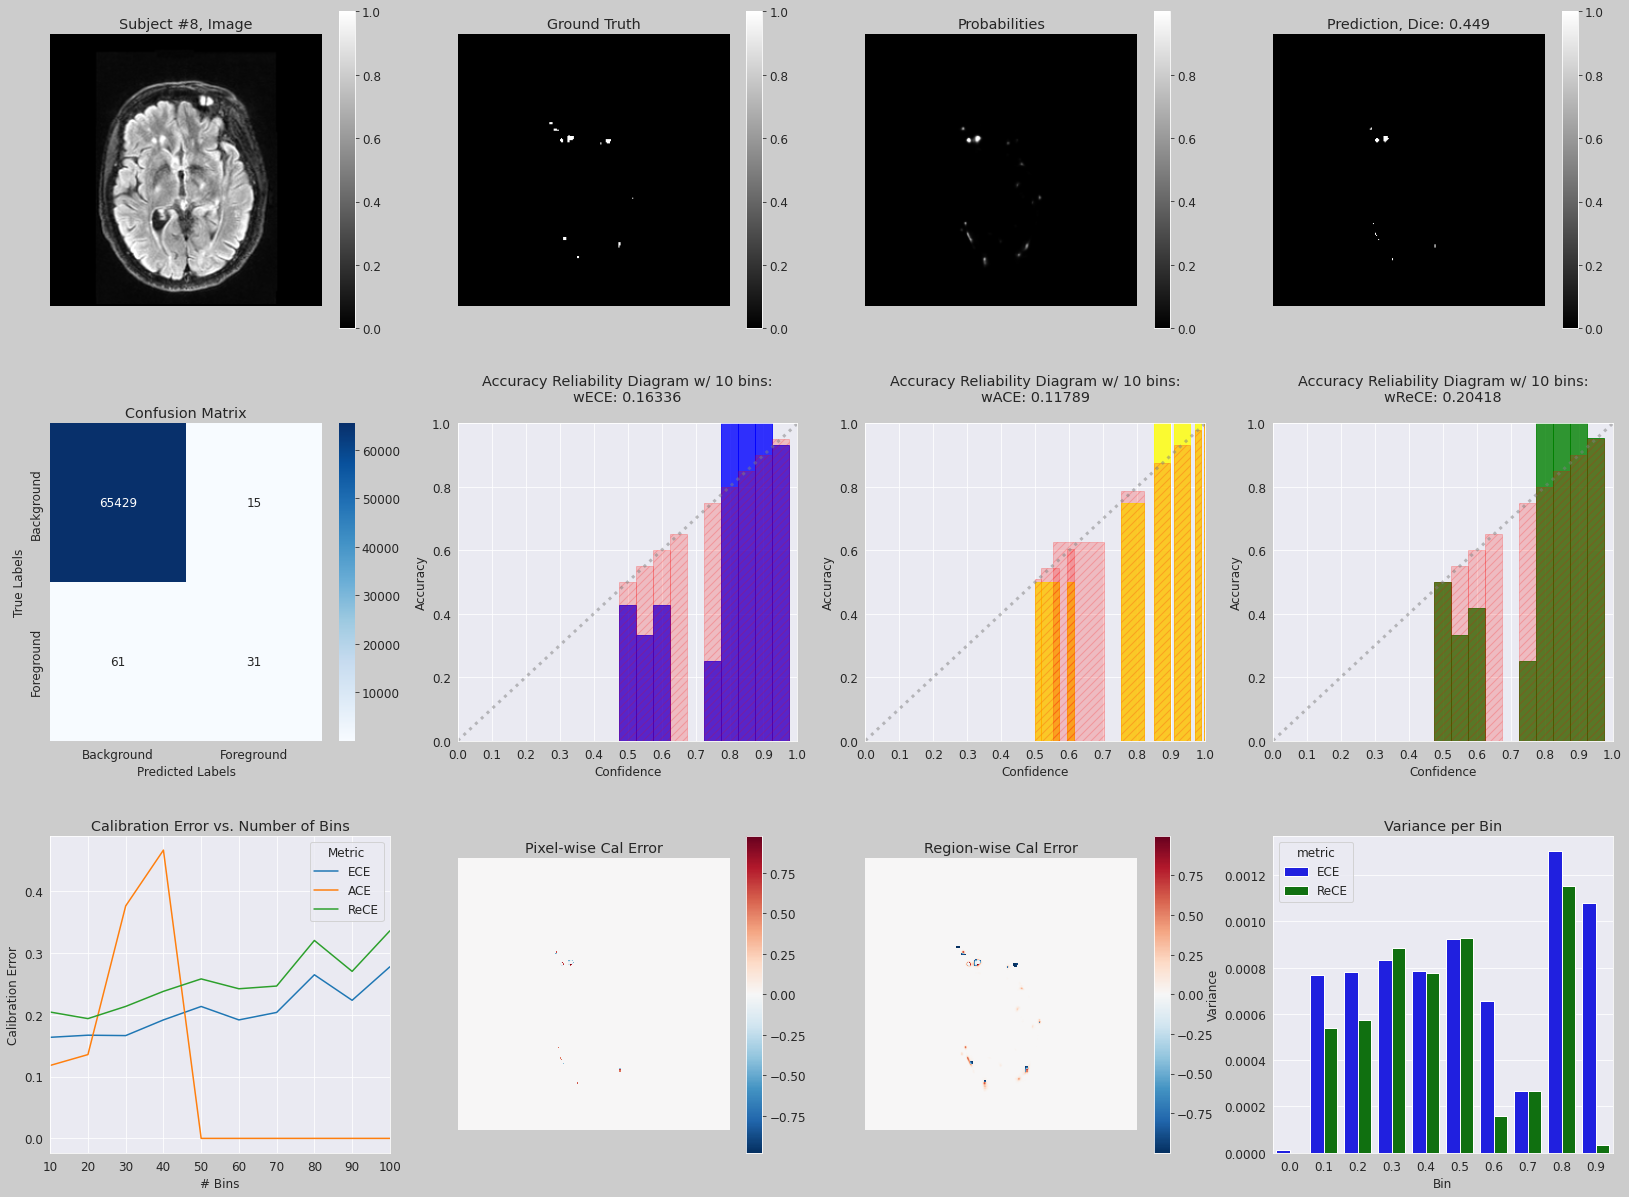

Graph Bins:  tensor([])
Graph Bars:  tensor([])
Graph Widths:  tensor([])



IndexError: The shape of the mask [10] at index 0 does not match the shape of the indexed tensor [0] at index 0

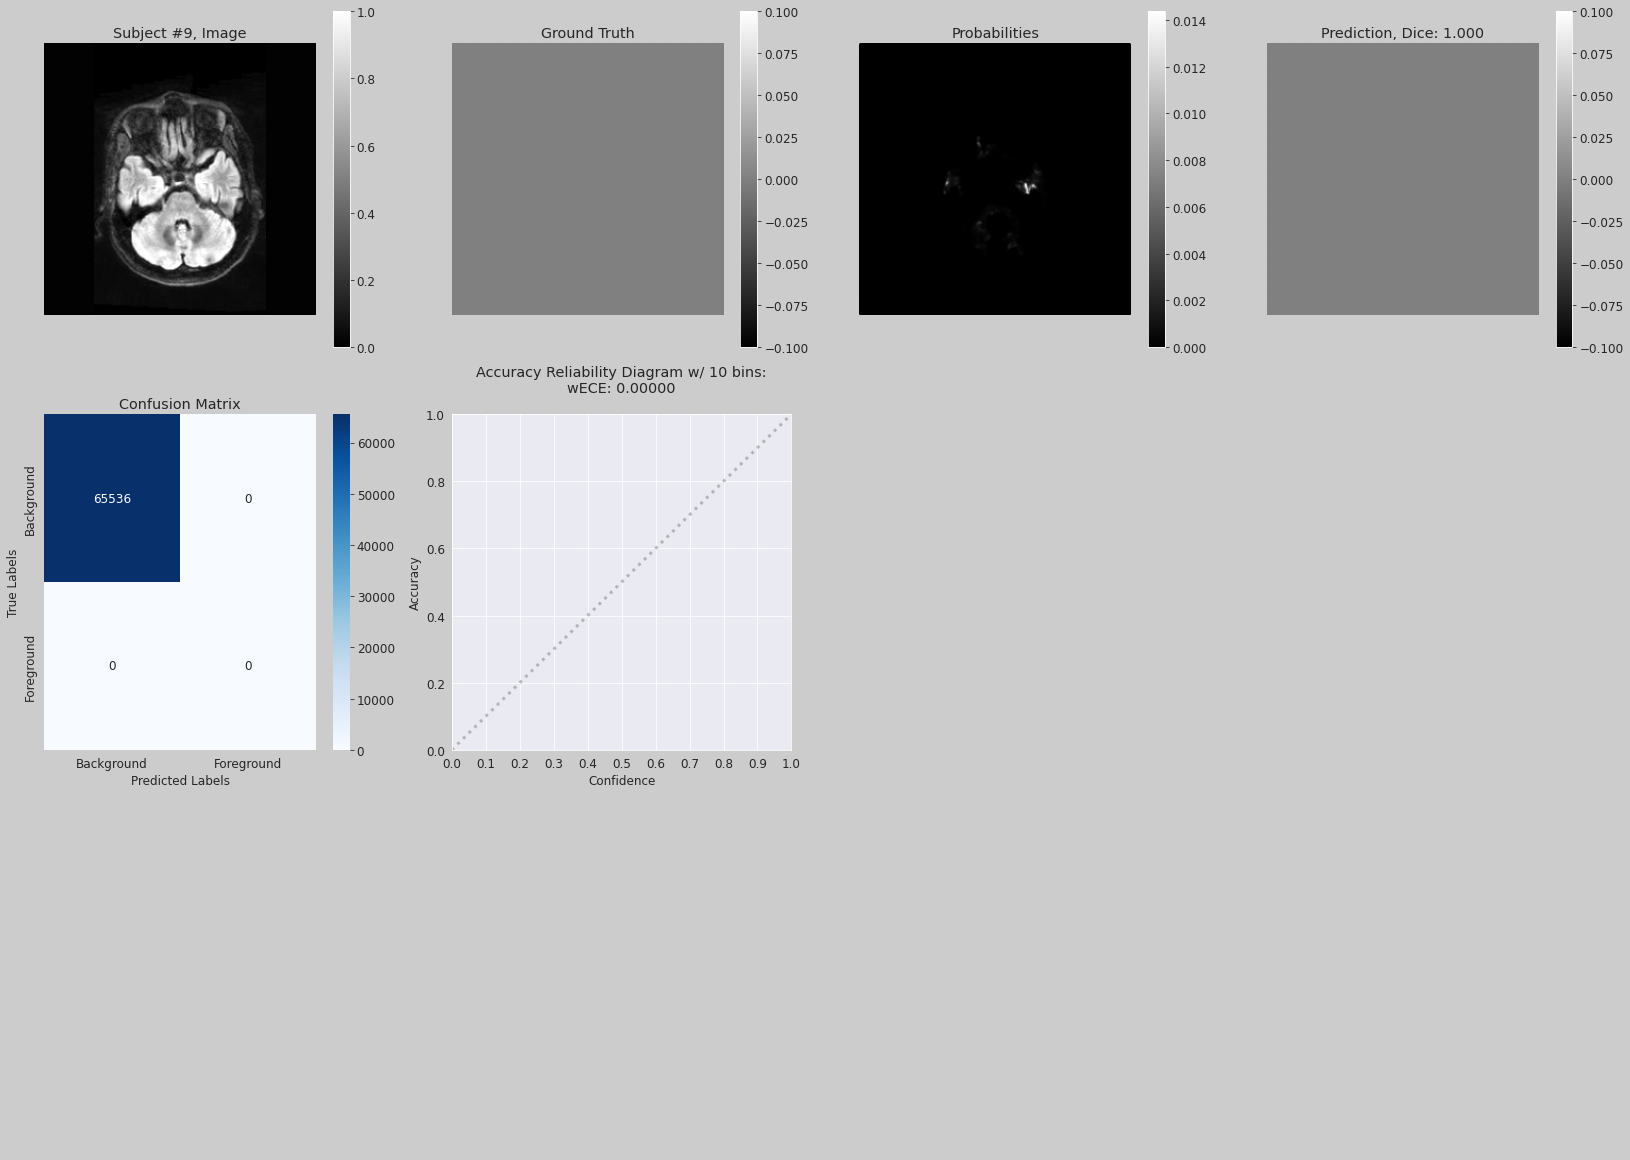

In [10]:
from ese.experiment.analysis.diagrams import subject_plot

subject_plot(
    subject_dict=predictions_dict,
    num_bins=10,
    remove_empty_bins=False,
    show_bin_amounts=False,
    include_background=False,
    metrics=["ECE", "ACE", "ReCE"],
    bin_weightings=["weighted"]
)

In [ ]:
from ese.experiment.analysis.diagrams import aggregate_reliability_plot 

aggregate_reliability_plot(
    subject_dict=predictions_dict,
    num_bins=10,
    metrics=["ECE", "ACE", "ReCE"],
    bin_weightings=["weighted"]
)

In [ ]:
from ese.experiment.analysis.diagrams import aggregate_cm_plot

aggregate_cm_plot(
    subj_dict=predictions_dict
)

In [ ]:
from ese.experiment.analysis.diagrams import aggregate_error_distribution_plot

aggregate_error_distribution_plot(
    subject_dict=predictions_dict,
    num_bins=10,
    metrics=["ECE", "ACE", "ReCE"],
    bin_weightings=["weighted"]
)